In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

from datetime import datetime

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import sqlite3

In [31]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [32]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = 'data/' + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        self.start_time = None
        self.end_time = None

        # acceleration.csvがない場合は作成する
        if 'acceleration.csv' not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)
        
        # 'all.csv'がある場合は削除する
        if 'all.csv' in self.file_names:
            self.file_names.remove('all.csv')
        
        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace('.csv', '')

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(columns={'x': file_type + '_x', 'y': file_type + '_y', 'z': file_type + '_z'})
            
            # 'rotate.csv' に 'w' 列がある場合は削除
            if 'w' in df_tmp.columns and file_name == 'rotate.csv':
                df_tmp = df_tmp.drop(['w'], axis=1)

            if type(df_tmp['time'][0]) == int:
                # 'time'列の変換を実行
                df_tmp['time'] = df_tmp['time'] / 1000
                df_tmp['time'] = pd.to_datetime(df_tmp['time'], unit='s')

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[:, [0] + [i for i in range(1, len(self.df.columns)) if not self.df.columns[i].startswith('time')]]
        self.df['time'] =pd.to_datetime(self.df['time']/1000,unit='s')

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, 'all.csv'), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, 'velocity.csv'))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        df_acc['x'] = df_tmp['x'].cumsum()
        df_acc['y'] = df_tmp['y'].cumsum()
        df_acc['z'] = df_tmp['z'].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, 'acceleration.csv'), index=False)
        df_acc = df_acc.drop(['time'],axis =1 )
        df_acc['acceleration_x'] = df_acc['x']
        df_acc['acceleration_y'] = df_acc['y']
        df_acc['acceleration_z'] = df_acc['z']
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_low_x'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
            column = column_type + '_y'
            out_column = column_type + '_low_y'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
            column = column_type + '_z'
            out_column = column_type + '_low_z'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
        return self

    def high_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.high_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_high_x'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_y'
            out_column = column_type + '_high_y'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_z'
            out_column = column_type + '_high_z'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
        return self
    
    def diff(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.diff(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_diff_x'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_y'
            out_column = column_type + '_diff_y'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_z'
            out_column = column_type + '_diff_z'
            self.df[out_column] = self.df[column].diff()
        return self
    
    def reverse(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.norm(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_reverse_x'
            self.df[out_column] = self.df[column] * -1
            column = column_type + '_y'
            out_column = column_type + '_reverse_y'
            self.df[out_column] = self.df[column] * -1
            column = column_type + '_z'
            out_column = column_type + '_reverse_z'
            self.df[out_column] = self.df[column] * -1
        return self

    def plot(self, column_type ,option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))
        
        if column_type == 'all':
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    continue
                self.ax(column, option,axis)
                self.i += 1
        else:
            column_type = column_type.replace('.csv', '')
            self.ax(column_type, option,axis)
        plt.show()

    def ax(self, column_type ,option,axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i+1)
        match option:
            case "axvspan":
                self.axvspan(column_type)
            case "diff":
                column_type = column_type + '_diff'
            case "high":
                column_type = column_type + '_high'
            case "low":
                column_type = column_type + '_low'  
            case "reverse":
                column_type = column_type + '_reverse'
        match axis:
            case 'x':
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
            case 'y':
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
            case 'z':
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
            case _:
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel('time')
        ax.set_ylabel(column_type)
        ax.grid()

    def axvspan(self,column_type):
        ax.axvspan(self.start_time, self.end_time, color='red', alpha=0.5)

    def split_time(self, start_time, end_time):
        self.df = self.df[(self.df['time'] >= start_time) & (self.df['time'] <= end_time)]
        return self

In [33]:
# walk_stairsのデータを読み込む
walk_stairs = Data('walk_stairs')
walk_stairs.low_filter('all', filter_num)

In [34]:
# # データの最初の時間を取得
# walk_stairs.start_time = walk_stairs.df['time'][0]
# print(walk_stairs.start_time)

# # 時間を制限する
# start_time = walk_stairs.start_time
# end_time = '2023-11-27 08:02:00'
# walk_stairs.split_time(start_time, end_time)

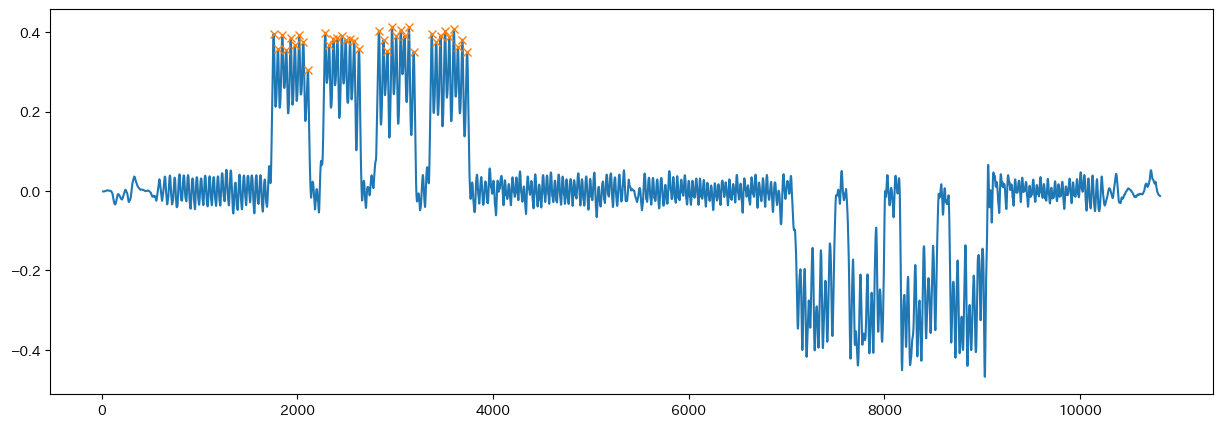

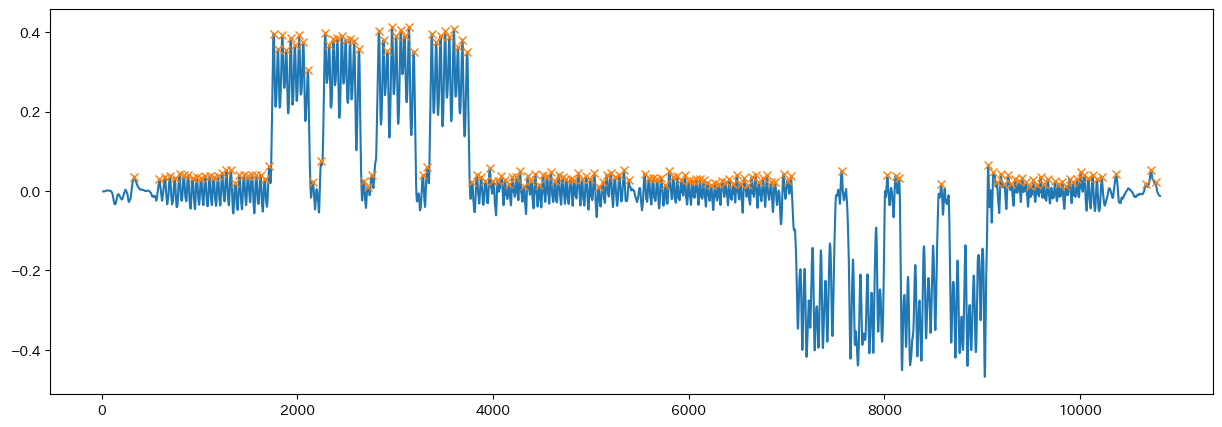

In [35]:
# ローパスフィルタ
walk_stairs.low_filter('all', int(filter_num/2))

# velocity_yのピークを検出する
peaks, _ = find_peaks(walk_stairs.df['velocity_low_y'], height=0.3, distance=20)
fig = plt.figure(figsize=(15, 5))
plt.plot(walk_stairs.df['velocity_low_y'])
plt.plot(peaks, walk_stairs.df['velocity_low_y'][peaks], "x")
plt.show()

# velocity_yのピークを検出する
peaks, _ = find_peaks(walk_stairs.df['velocity_low_y'], height=0.01, distance=20)
fig = plt.figure(figsize=(15, 5))
plt.plot(walk_stairs.df['velocity_low_y'])
plt.plot(peaks, walk_stairs.df['velocity_low_y'][peaks], "x")
plt.show()

In [36]:
# walk_stairsのposition_diff_yからpeekを取得して、そのpeekの時間を取得する
peek, _ = signal.find_peaks(walk_stairs.df['velocity_low_y'], distance=22, height=0.01)

peek_df = pd.DataFrame()
peek_df['time'] = walk_stairs.df['time']

# indexの初期値を取得する
peek_first = walk_stairs.df.index[0]

# timeをずらす
peek_df['shift_time'] = peek_df['time'] - pd.Timedelta(seconds=1)

# indexの初期値を取得する
peek_first = walk_stairs.df.index[0]
# peekに初期値を足す
peek = peek + peek_first
# peekの時間を取得する
peek_time = walk_stairs.df['time'][peek]

# 階段を登っているか、平面を歩いているかを判定する
# peekのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peek_df['status'] = 'none'
for i in range(len(peek)):
    if walk_stairs.df['velocity_y'][peek[i]] > 0.2:
        peek_df['status'][peek[i]] = 'stairs'
    elif walk_stairs.df['velocity_y'][peek[i]] > 0.01:
        peek_df['status'][peek[i]] = 'flat'
    else:
        peek_df['status'][peek[i]] = 'none'

# peek_dfからstatusがnoneの行を削除する
# peek_df = peek_df[peek_df['status'] != 'none']

# 階段を登る、平面を歩くを判定する
peek_stair_df = peek_df[peek_df['status'] == 'stairs']
peek_flat_df = peek_df[peek_df['status'] == 'flat']

# それぞれのindexをリストに
peek_stairs = [index for index in peek_stair_df.index]
peek_flats = [index for index in peek_flat_df.index]

# numpyに変換する
peek_stair = np.array(peek_stairs)
peek_flat = np.array(peek_flats)

peek_stair_time = walk_stairs.df['time'][peek_stair]
peek_flat_time = walk_stairs.df['time'][peek_flat]

# export sqlite
conn = sqlite3.connect('stairs.db')
c = conn.cursor()
c.execute('DROP TABLE IF EXISTS stairs')
c.execute('CREATE TABLE stairs (time TEXT, shift_time TEXT, status TEXT)')
peek_df.to_sql('stairs', conn, if_exists='replace')
conn.commit()

"""
-- SQLite
SELECT * FROM stairs WHERE status LIKE '%stair%' OR status LIKE '%flat%';
"""

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/1872875403.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peek_df['status'][peek[i]] = 'flat'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/1872875403.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peek_df['status'][peek[i]] = 'flat'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/1872875403.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

"\n-- SQLite\nSELECT * FROM stairs WHERE status LIKE '%stair%' OR status LIKE '%flat%';\n"

In [37]:
print(peek_stair)
print(peek_flat)


[1758 1802 1846 1887 1932 1975 2018 2061 2108 2243 2285 2325 2369 2409
 2455 2494 2538 2581 2630 2834 2881 2921 2968 3010 3057 3096 3140 3189
 3374 3419 3464 3510 3553 3600 3641 3686 3736 4793 6343 9115 9265]
[  335   591   646   698   746   796   840   883   929   973  1017  1058
  1103  1145  1189  1232  1275  1320  1367  1409  1455  1496  1534  1581
  1624  1668  1713  2158  2680  2720  2760  3284  3328  3787  3837  3881
  3923  3966  4004  4047  4086  4122  4162  4199  4239  4276  4316  4355
  4393  4432  4472  4512  4552  4592  4633  4671  4712  4751  4829  4872
  4910  4952  4993  5036  5080  5123  5162  5205  5247  5292  5339  5387
  5550  5594  5635  5678  5720  5761  5802  5843  5883  5924  5961  6000
  6039  6078  6115  6155  6191  6229  6267  6305  6378  6416  6455  6492
  6530  6569  6605  6643  6684  6719  6759  6799  6843  6882  6969  7010
  7045  7563  8031  8114  8149  8581  9147  9190  9226  9299  9337  9376
  9409  9447  9484  9522  9558  9596  9631  9670  9745  9780 

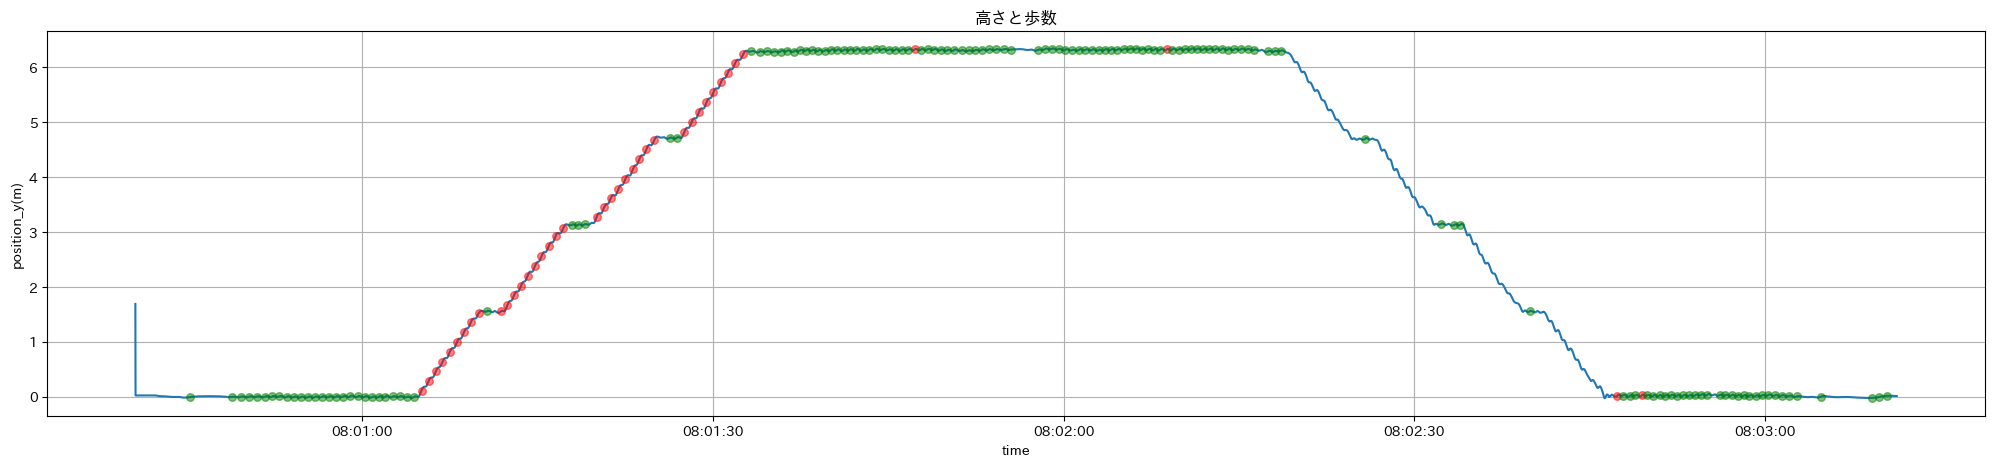

In [59]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
# ax.plot(walk_stairs.df['time'], walk_stairs.df['position_x'])
ax.plot(walk_stairs.df['time'], walk_stairs.df['position_y'])
# ax.plot(walk_stairs.df['time'], walk_stairs.df['position_z'])
# 後ろを全体で塗る
# ax.fill_between(peek_df['time'], -2, 7, where=(peek_df['status'] == 'stairs'), facecolor='blue', alpha=0.2)
# ax.fill_between(peek_df['time'], -2, 7, where=(peek_df['position_pro_y'] == 1), facecolor='blue', alpha=0.2)
ax.scatter(peek_stair_time, walk_stairs.df['position_y'][peek_stair], s=30, color='red', zorder=2,alpha=0.5)
ax.scatter(peek_flat_time, walk_stairs.df['position_y'][peek_flat], s=30, color='green', zorder=2,alpha=0.5)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.grid()
plt.show()

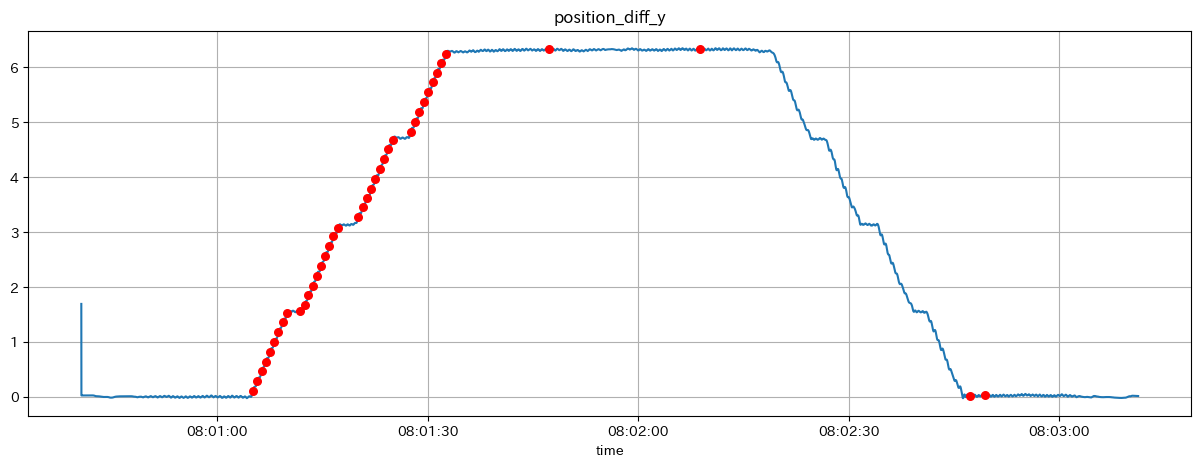

In [39]:
# peekをプロットする
fig = plt.figure(figsize=(15, 5))
plt.plot(walk_stairs.df['time'], walk_stairs.df['position_y'])
plt.scatter(peek_stair_time, walk_stairs.df['position_y'][peek_stair], s=30, color='red', zorder=2)
plt.title('position_diff_y')
plt.xlabel('time')
plt.grid()
plt.show()

In [40]:
print(peek_stairs)
print(peek_flats)

[1758, 1802, 1846, 1887, 1932, 1975, 2018, 2061, 2108, 2243, 2285, 2325, 2369, 2409, 2455, 2494, 2538, 2581, 2630, 2834, 2881, 2921, 2968, 3010, 3057, 3096, 3140, 3189, 3374, 3419, 3464, 3510, 3553, 3600, 3641, 3686, 3736, 4793, 6343, 9115, 9265]
[335, 591, 646, 698, 746, 796, 840, 883, 929, 973, 1017, 1058, 1103, 1145, 1189, 1232, 1275, 1320, 1367, 1409, 1455, 1496, 1534, 1581, 1624, 1668, 1713, 2158, 2680, 2720, 2760, 3284, 3328, 3787, 3837, 3881, 3923, 3966, 4004, 4047, 4086, 4122, 4162, 4199, 4239, 4276, 4316, 4355, 4393, 4432, 4472, 4512, 4552, 4592, 4633, 4671, 4712, 4751, 4829, 4872, 4910, 4952, 4993, 5036, 5080, 5123, 5162, 5205, 5247, 5292, 5339, 5387, 5550, 5594, 5635, 5678, 5720, 5761, 5802, 5843, 5883, 5924, 5961, 6000, 6039, 6078, 6115, 6155, 6191, 6229, 6267, 6305, 6378, 6416, 6455, 6492, 6530, 6569, 6605, 6643, 6684, 6719, 6759, 6799, 6843, 6882, 6969, 7010, 7045, 7563, 8031, 8114, 8149, 8581, 9147, 9190, 9226, 9299, 9337, 9376, 9409, 9447, 9484, 9522, 9558, 9596, 9631, 

In [41]:
# peek_stairsでpeek_flatsが間にない区間を取得する
peek_observe = []
peek_observe_time = []

tmp = []
time_tmp = []

peek_stairs_tmp = peek_stairs[:]

for falt in peek_flats:
    for stair in peek_stairs_tmp[:]:  # copy peek_stairs
        if stair < falt:
            tmp.append(stair)
            time_tmp.append(walk_stairs.df['time'][stair])
            peek_stairs_tmp.remove(stair)  # remove stair from peek_stairs
    if len(tmp) > 0:
        peek_observe.append(tmp)
        peek_observe_time.append(time_tmp)
        tmp = []
        time_tmp = []

print(peek_observe)
print(peek_observe_time)


floor_peek = peek_observe
floor = len(floor_peek)
print(floor)
print(floor_peek)

[[1758, 1802, 1846, 1887, 1932, 1975, 2018, 2061, 2108], [2243, 2285, 2325, 2369, 2409, 2455, 2494, 2538, 2581, 2630], [2834, 2881, 2921, 2968, 3010, 3057, 3096, 3140, 3189], [3374, 3419, 3464, 3510, 3553, 3600, 3641, 3686, 3736], [4793], [6343], [9115], [9265]]
[[Timestamp('2023-11-27 08:01:05.115000064'), Timestamp('2023-11-27 08:01:05.724999936'), Timestamp('2023-11-27 08:01:06.336000'), Timestamp('2023-11-27 08:01:06.907000064'), Timestamp('2023-11-27 08:01:07.536999936'), Timestamp('2023-11-27 08:01:08.137000192'), Timestamp('2023-11-27 08:01:08.736000'), Timestamp('2023-11-27 08:01:09.342999808'), Timestamp('2023-11-27 08:01:09.997999872')], [Timestamp('2023-11-27 08:01:11.878000128'), Timestamp('2023-11-27 08:01:12.461999872'), Timestamp('2023-11-27 08:01:13.017999872'), Timestamp('2023-11-27 08:01:13.628999936'), Timestamp('2023-11-27 08:01:14.184000'), Timestamp('2023-11-27 08:01:14.824000'), Timestamp('2023-11-27 08:01:15.364000'), Timestamp('2023-11-27 08:01:15.974999808'), 

In [42]:
# 1段の高さ
floor_step_high = 0
floor_step_high_tmp = 0
floor_step_highs = []
for n in floor_peek:
    num = 0
    for i in range(len(n)):
        if i == len(n)-1:
            break
        before_peek_point = n[i]
        after_peek_point = n[i+1]
        stair_step = walk_stairs.df['position_y'][after_peek_point] - walk_stairs.df['position_y'][before_peek_point]
        # print(f"{i} after  : {walk_stairs.df['position_y'][after_peek_point]} , before : {walk_stairs.df['position_y'][before_peek_point]} , diff   : {stair_step}")
        floor_step_high_tmp += stair_step

    floor_step_high_tmp = floor_step_high_tmp / len(n)
    floor_step_highs.append(floor_step_high_tmp)
    print(f"1段の高さ : {floor_step_high_tmp}")

print(floor_step_highs)
average_floor_step_high = sum(floor_step_highs) / len(floor_step_highs)
print(f"平均の1段の高さ : {average_floor_step_high}")

1段の高さ : 0.15620342222222222
1段の高さ : 0.1682431422222222
1段の高さ : 0.17454146024691355
1段の高さ : 0.17630960669410145
1段の高さ : 0.17630960669410145
1段の高さ : 0.17630960669410145
1段の高さ : 0.17630960669410145
1段の高さ : 0.17630960669410145
[0.15620342222222222, 0.1682431422222222, 0.17454146024691355, 0.17630960669410145, 0.17630960669410145, 0.17630960669410145, 0.17630960669410145, 0.17630960669410145]
平均の1段の高さ : 0.17256700727023316


/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/40792062.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high'][peek_point] = tmp + floor_step_highs[i]


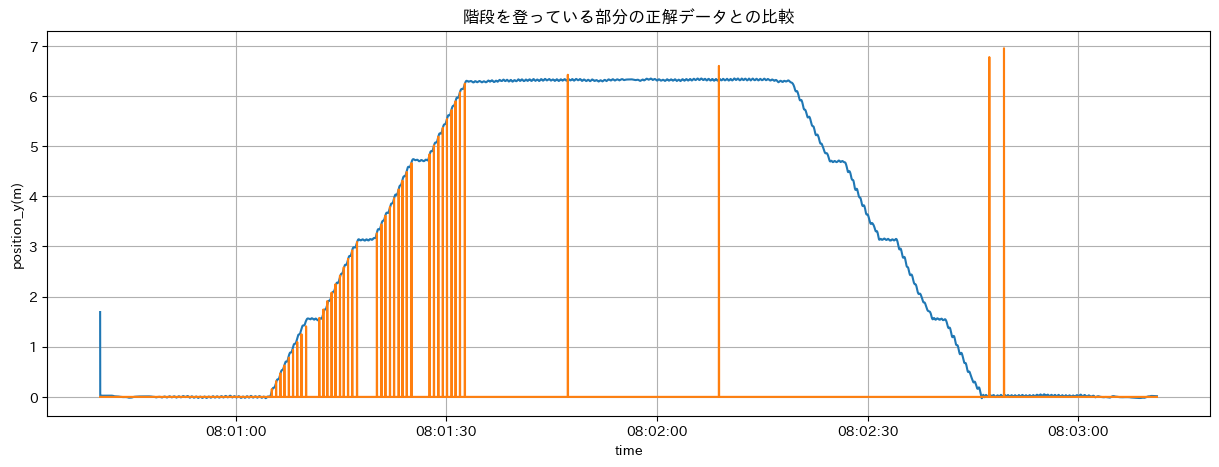

In [43]:
# peekの時間に合わせて、floor_step_highsを加算したリストを作成する
floor_step_df = pd.DataFrame()
floor_step_df['time'] = walk_stairs.df['time']
floor_step_df['position_y'] = walk_stairs.df['position_y']
# floor_step_df['position_pro_y'] = peek_df['position_pro_y']
floor_step_df['floor_step_high'] = 0

# floor_step_dfにfloor_step_highsを加算する
n = 0
tmp = 0
for i in range(floor):
    # floor_peekに入っているpeekの数だけ繰り返す
    for peek_point in floor_peek[i]:
        floor_step_df['floor_step_high'][peek_point] = tmp + floor_step_highs[i]
        tmp = tmp + floor_step_highs[i]

# plotする
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(floor_step_df['time'], floor_step_df['position_y'])
ax.plot(floor_step_df['time'], floor_step_df['floor_step_high'])
ax.set_title('階段を登っている部分の正解データとの比較')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.grid()
plt.show()

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/4047915602.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high'][peek_point] = tmp + average_floor_step_high


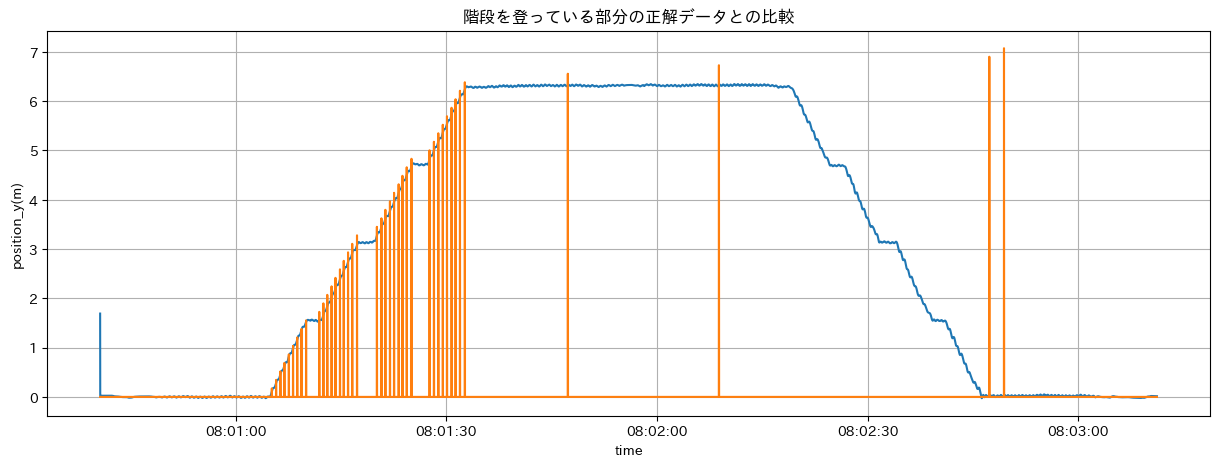

In [44]:
# peekの時間に合わせて、floor_step_highsを加算したリストを作成する
floor_step_df = pd.DataFrame()
floor_step_df['time'] = walk_stairs.df['time']
floor_step_df['position_y'] = walk_stairs.df['position_y']
# floor_step_df['position_pro_y'] = peek_df['position_pro_y']
floor_step_df['floor_step_high'] = 0

# floor_step_dfにfloor_step_highsを加算する
n = 0
tmp = 0
for i in range(floor):
    # floor_peekに入っているpeekの数だけ繰り返す
    for peek_point in floor_peek[i]:
        floor_step_df['floor_step_high'][peek_point] = tmp + average_floor_step_high
        tmp = tmp + average_floor_step_high

# plotする
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(floor_step_df['time'], floor_step_df['position_y'])
ax.plot(floor_step_df['time'], floor_step_df['floor_step_high'])
ax.set_title('階段を登っている部分の正解データとの比較')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.grid()
plt.show()

In [45]:
# floor_step_df['floor_step_high']の値が0のとき、floor_step_df['floor_step_high']の値をそれまでの最大値にする
floor_step_df['floor_step_high_pro'] = floor_step_df['floor_step_high']
for i in range(len(floor_step_df['floor_step_high_pro'])):
    floor_step_df['floor_step_high_pro'][i] = floor_step_df['floor_step_high_pro'][:i].max()

floor_step_df['shift_time'] = floor_step_df['time'] + pd.Timedelta(seconds=4)

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/2205816857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high_pro'][i] = floor_step_df['floor_step_high_pro'][:i].max()
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/2205816857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floor_step_df['floor_step_high_pro'][i] = floor_step_df['floor_step_high_pro'][:i].max()
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/2205816857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

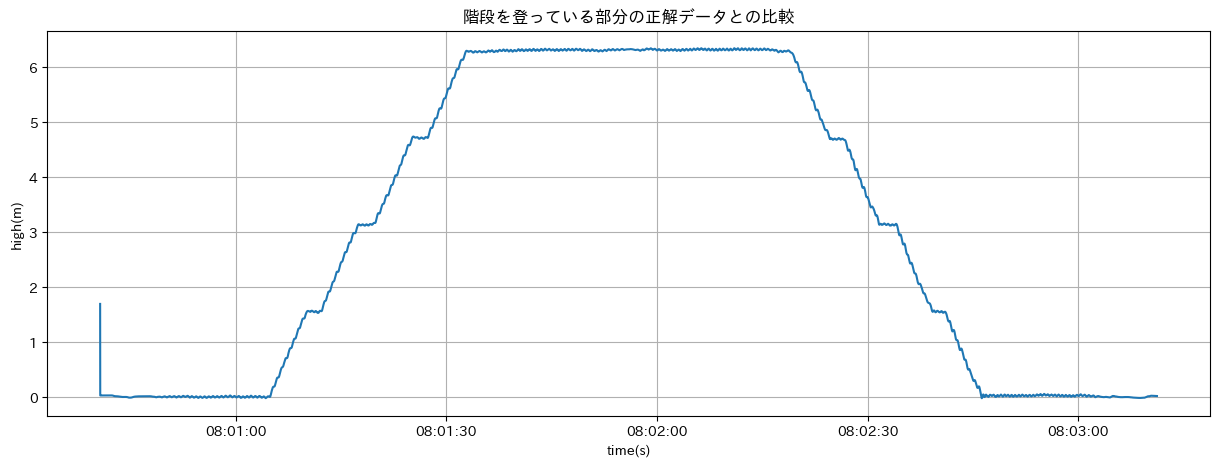

In [46]:
# floor_step_dfの['floor_step_high']を表示する
fig = plt.figure(figsize=(15, 5))
plt.plot(floor_step_df['time'], floor_step_df['position_y'])
# plt.plot(floor_step_df['time'], floor_step_df['floor_step_high'])
plt.plot(floor_step_df['shift_time'], floor_step_df['floor_step_high_pro'])
plt.title('階段を登っている部分の正解データとの比較')
plt.xlabel('time(s)')
plt.ylabel('high(m)')
plt.grid()
plt.show()

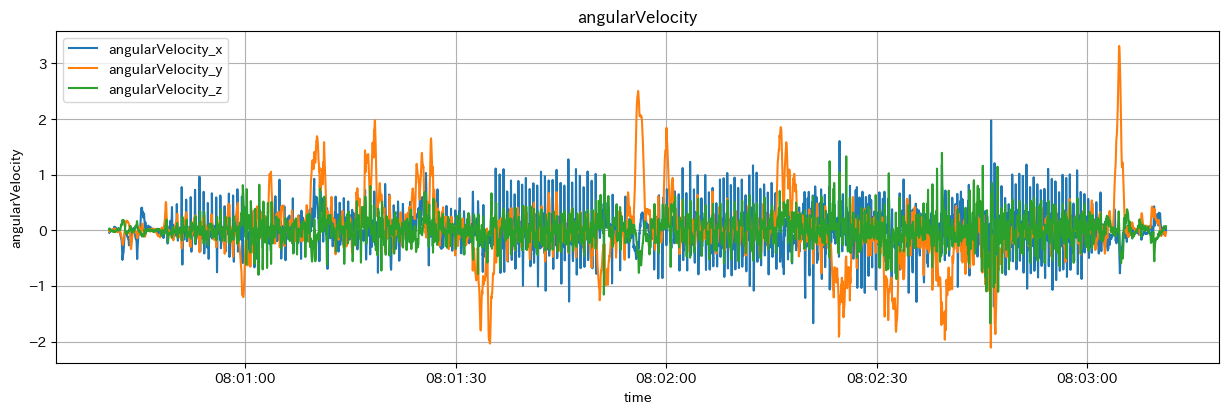

In [47]:
walk_stairs.plot('angularVelocity', 'all','')

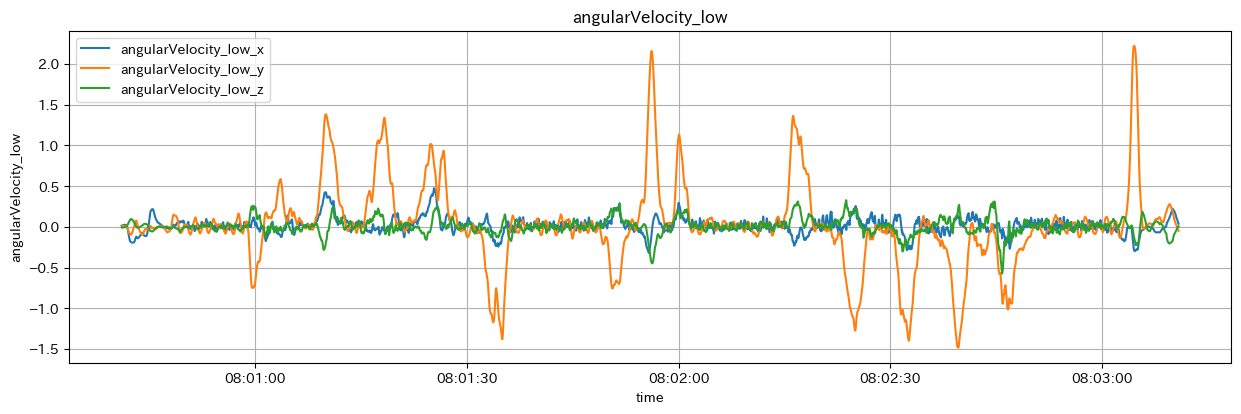

In [48]:
walk_stairs.low_filter('angularVelocity', filter_num)
walk_stairs.plot('angularVelocity_low', '','')

[ 2111  2639  2708  3179  3312  5433  5713  6876  6950  7020 10350]
0
[ 2111  2639  2708  3179  3312  5433  5713  6876  6950  7020 10350]
2111    2023-11-27 08:01:10.039000064
2639    2023-11-27 08:01:17.379000064
2708    2023-11-27 08:01:18.336999936
3179    2023-11-27 08:01:24.879000064
3312    2023-11-27 08:01:26.724999936
5433    2023-11-27 08:01:56.183000064
5713    2023-11-27 08:02:00.072000000
6876    2023-11-27 08:02:16.223000064
6950    2023-11-27 08:02:17.249999872
7020    2023-11-27 08:02:18.220999936
10350   2023-11-27 08:03:04.494999808
Name: time, dtype: datetime64[ns]


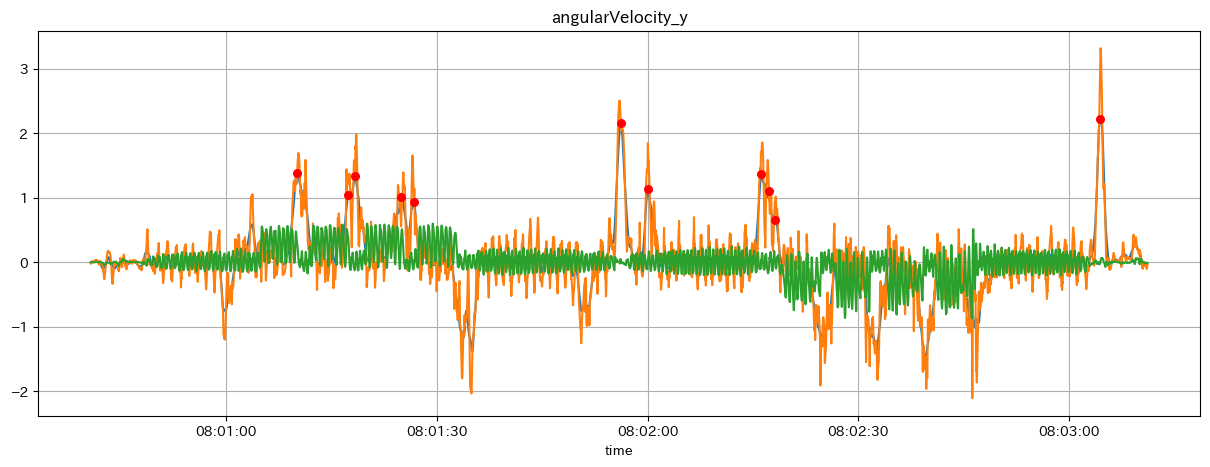

In [49]:
# peek
peek, _ = signal.find_peaks(walk_stairs.df['angularVelocity_low_y'], distance=66, height=0.6)
print(peek)

print(walk_stairs.df.index[0])

peek = peek + walk_stairs.df.index[0]

print(peek)

# peekの時間を取得する
peek_time = walk_stairs.df['time'][peek]
print(peek_time)

# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(walk_stairs.df['time'], walk_stairs.df['angularVelocity_low_y'])
plt.plot(walk_stairs.df['time'], walk_stairs.df['angularVelocity_y'])
plt.plot(walk_stairs.df['time'], walk_stairs.df['velocity_y'])
plt.scatter(peek_time, walk_stairs.df['angularVelocity_low_y'][peek], s=30, color='red', zorder=2)
plt.title('angularVelocity_y')
plt.xlabel('time')
plt.grid()
plt.show()


[1753 1799 1844 1892 1929 1969 2015 2054 2100 2279 2321 2362 2407 2448
 2495 2536 2579 2623 2832 2874 2918 2962 3007 3053 3095 3138 3187 3374
 3412 3458 3504 3552 3593 3641 3682 3733 9048]
0
[1753 1799 1844 1892 1929 1969 2015 2054 2100 2279 2321 2362 2407 2448
 2495 2536 2579 2623 2832 2874 2918 2962 3007 3053 3095 3138 3187 3374
 3412 3458 3504 3552 3593 3641 3682 3733 9048]
1753   2023-11-27 08:01:05.045000192
1799   2023-11-27 08:01:05.684000000
1844   2023-11-27 08:01:06.308999936
1892   2023-11-27 08:01:06.976999936
1929   2023-11-27 08:01:07.494999808
1969   2023-11-27 08:01:08.053999872
2015   2023-11-27 08:01:08.694999808
2054   2023-11-27 08:01:09.237999872
2100   2023-11-27 08:01:09.887000064
2279   2023-11-27 08:01:12.378000128
2321   2023-11-27 08:01:12.961999872
2362   2023-11-27 08:01:13.532000000
2407   2023-11-27 08:01:14.156000000
2448   2023-11-27 08:01:14.726000128
2495   2023-11-27 08:01:15.377000192
2536   2023-11-27 08:01:15.948000000
2579   2023-11-27 08:01:16.5

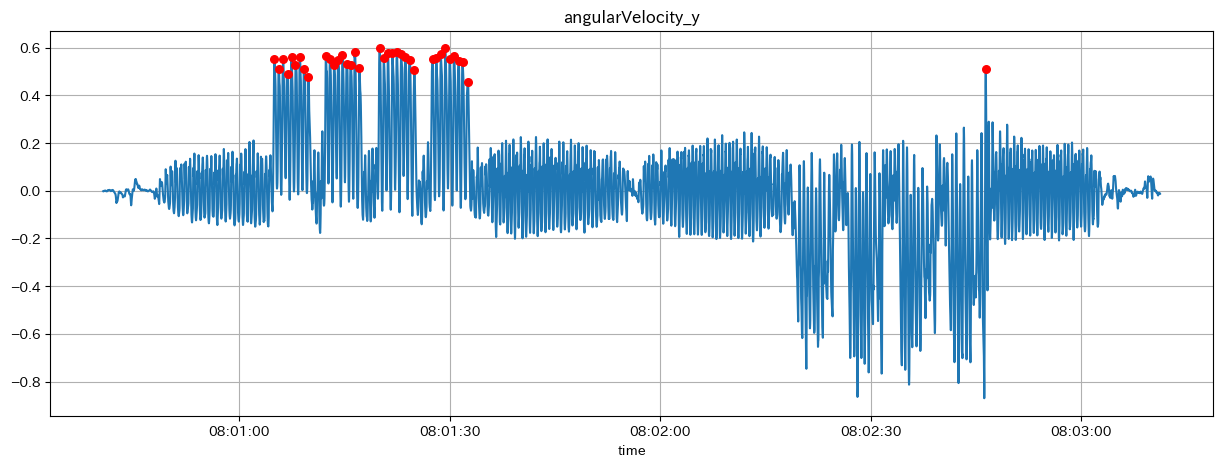

In [50]:
# peekを検出
velocity_peek, _ = signal.find_peaks(walk_stairs.df['velocity_y'], distance=22, height=0.4)

print(velocity_peek)

print(walk_stairs.df.index[0])

velocity_peek = velocity_peek + walk_stairs.df.index[0]

print(velocity_peek)

# peekの時間を取得する
velocity_peek_time = walk_stairs.df['time'][velocity_peek]
print(velocity_peek_time)

# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(walk_stairs.df['time'], walk_stairs.df['velocity_y'])
plt.scatter(velocity_peek_time, walk_stairs.df['velocity_y'][velocity_peek], s=30, color='red', zorder=2)
plt.title('angularVelocity_y')
plt.xlabel('time')
plt.grid()
plt.show()

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/1397229071.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walk_stairs.df['velocity_pro_high_y'][index] = 0
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/1397229071.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walk_stairs.df['velocity_pro_high_y'][index] = 0
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_85132/1397229071.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

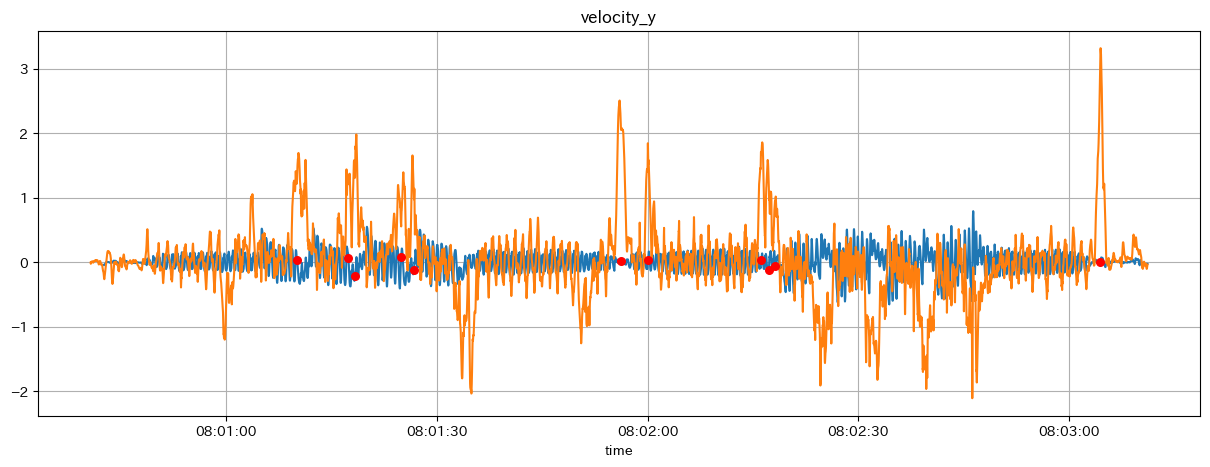

In [51]:
# velocityにハイカットフィルターをかける
# 0.25以上の時は0にする、それ以外はそのまま
walk_stairs.high_filter('velocity', filter_num*2)
walk_stairs.df['velocity_pro_high_y'] = walk_stairs.df['velocity_high_y']

# walk_stairs.df['velocity_pro_y']のtimeがpeek_df['position_pro_y'] == 1のところを0にする
for index in peek_df.index:
    if peek_df['status'][index] == 'stairs':
        index -= 33
        walk_stairs.df['velocity_pro_high_y'][index] = 0

walk_stairs.df['velocity_pro_y'] = walk_stairs.df['velocity_high_y'].apply(lambda x: 0 if x > 0.25 else x)

# plotする
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(walk_stairs.df['time'], walk_stairs.df['velocity_y'])
ax.plot(walk_stairs.df['time'], walk_stairs.df['velocity_high_y'])
# ax.plot(walk_stairs.df['time'], walk_stairs.df['velocity_pro_high_y'])
ax.plot(walk_stairs.df['time'], walk_stairs.df['angularVelocity_y'])
# ax.plot(walk_stairs.df['time'], walk_stairs.df['velocity_pro_y'])

# ax.fill_between(peek_df['shift_time'], -0.4, 0.4, where=(peek_df['position_pro_y'] == 1), facecolor='blue', alpha=0.2)
ax.scatter(peek_time, walk_stairs.df['velocity_pro_high_y'][peek], s=30, color='red', zorder=2)
plt.title('velocity_y')
plt.xlabel('time')
plt.grid()
plt.show()

In [52]:
# angular_velocityのyの最大値を取得する
max = walk_stairs.df['angularVelocity_y'].max()
print(max)

# indexを取得する
index = walk_stairs.df[walk_stairs.df['angularVelocity_y'] == max].index

# その時間を取得する
time = walk_stairs.df[walk_stairs.df['angularVelocity_y'] == max]['time']
print(time)

3.316253
10353   2023-11-27 08:03:04.538000128
Name: time, dtype: datetime64[ns]


In [53]:
# peekとindexで一番近い値を取得する
nears = []

for peek_point in peek:
    near = peek[np.abs(peek - peek_point).argmin()]
    nears.append(near)
print(nears)

[2111, 2639, 2708, 3179, 3312, 5433, 5713, 6876, 6950, 7020, 10350]


In [54]:
tmp_peek = peek

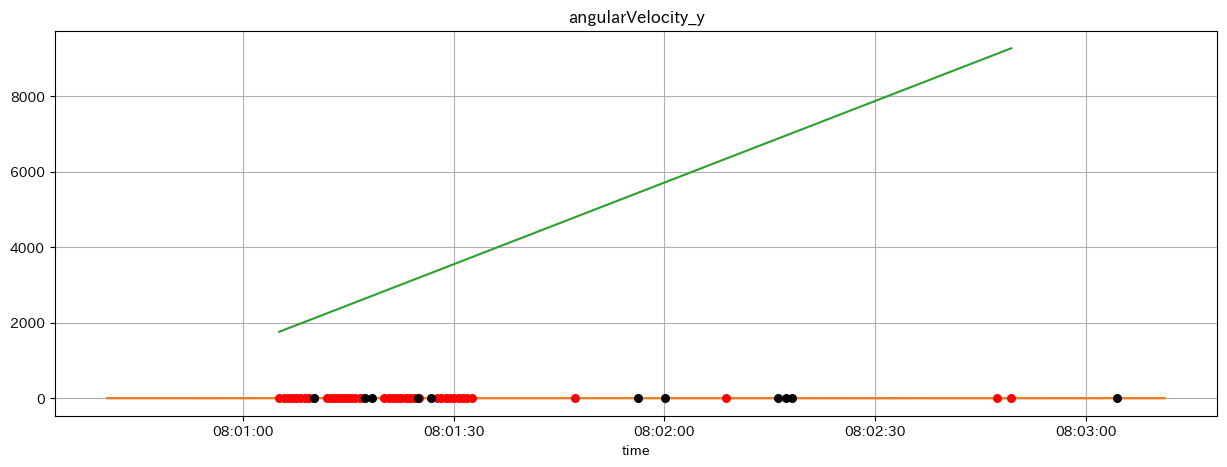

In [55]:
peek = tmp_peek
# plotする
fig = plt.figure(figsize=(15, 5))
plt.plot(walk_stairs.df['time'], walk_stairs.df['velocity_y'])
plt.plot(walk_stairs.df['time'], walk_stairs.df['angularVelocity_y'])
plt.plot(peek_stair_time, peek_stairs)
plt.scatter(peek_stair_time, walk_stairs.df['velocity_y'][peek_stair], s=30, color='red', zorder=2)
plt.scatter(peek_time, walk_stairs.df['angularVelocity_y'][peek], s=30, color='black', zorder=2)
plt.title('angularVelocity_y')
plt.xlabel('time')
plt.grid()
plt.show()

In [56]:
peek = tmp_peek
print(peek_stair)
print(peek)

# peek[4] += 33
# peek[3] += 33

# peekでvelocity_peekの中で一番近い値を取得する
peek_nears = []

for p in peek:
    near = peek_stair[np.abs(peek_stair - p).argmin()]
    # 既にpeek_nearsに入っている値は次の値を取得する
    if near in peek_nears:
        near = peek_stair[np.abs(peek_stair - p).argmin()+1]
        # どちらも既に入っている場合は無視
        if near in peek_nears:
            continue
    peek_nears.append(near)

print(peek_nears)

[1758 1802 1846 1887 1932 1975 2018 2061 2108 2243 2285 2325 2369 2409
 2455 2494 2538 2581 2630 2834 2881 2921 2968 3010 3057 3096 3140 3189
 3374 3419 3464 3510 3553 3600 3641 3686 3736 4793 6343 9115 9265]
[ 2111  2639  2708  3179  3312  5433  5713  6876  6950  7020 10350]
[2108, 2630, 2834, 3189, 3374, 4793, 6343, 9115, 9265]


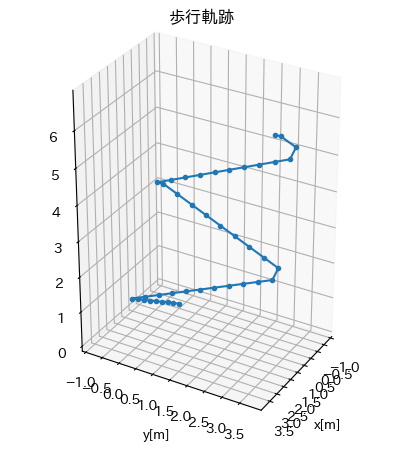

In [57]:
# 軌跡を描く
step = 0.4
x,y,z = 0,0,0
point = [[0, 0,0]]
direction_status = 'default'
for p in peek_stair:
    # p のときのpeek_df['position_pro_y'] == 1 かどうか判別
    if peek_df['status'][p] == 'stairs':
        # 1の時は1段上がっているので、z軸にstepを足す
        z += average_floor_step_high
    else:
        z += 0

    if direction_status == 'default':
        x += step
        y += 0
    elif direction_status == 'left1':
        x += 0
        y += step
    elif direction_status == 'left2':
        x -= step
        y += 0
    else:
        x += 0
        y -= step
    point.append([x, y,z])

    if p in peek_nears:
        if direction_status == 'default':
            direction_status = 'left1'
        elif direction_status == 'left1':
            direction_status = 'left2'
        elif direction_status == 'left2':
            direction_status = 'left3'
        else:
            direction_status = 'default'

# pointの[0,0]を削除する
point.pop(0)

point = pd.DataFrame(data=point, columns=['x', 'y','z'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]
point['z'] = point['z'] - point['z'][0]

size = ((-1,4),(-1,4))

# plot
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(projection='3d')
ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)

# plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)
plt.gca().set_aspect('equal', adjustable='box')

plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')

plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

# 視野の調整
angle = 30
ax.view_init(30, angle)

plt.show()


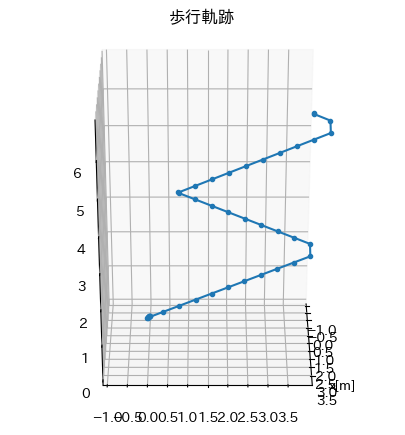

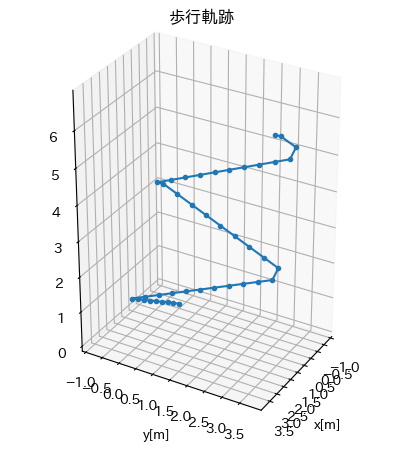

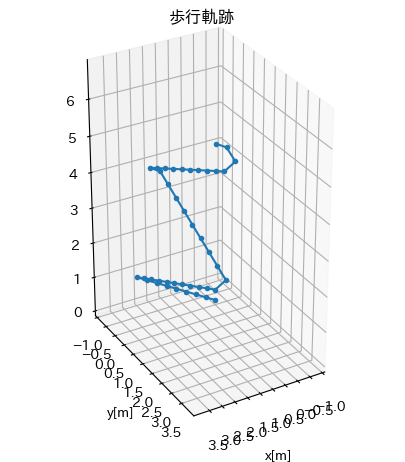

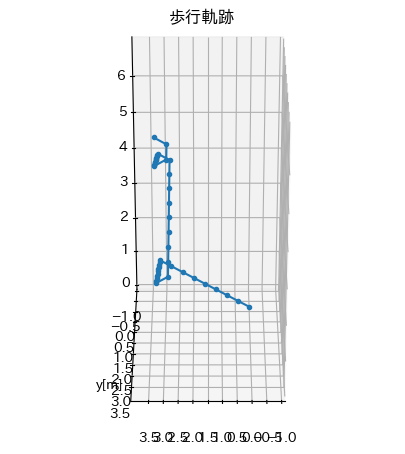

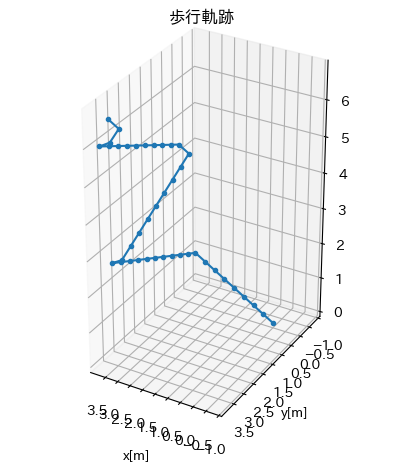

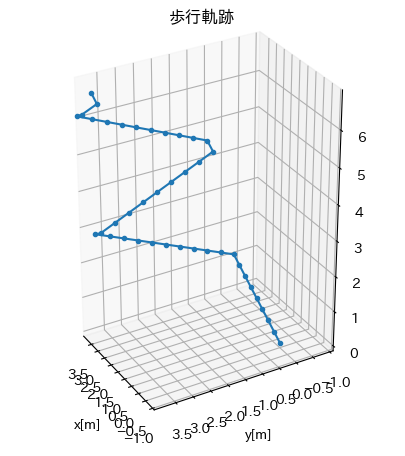

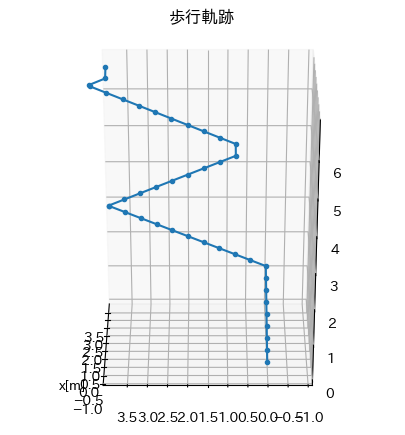

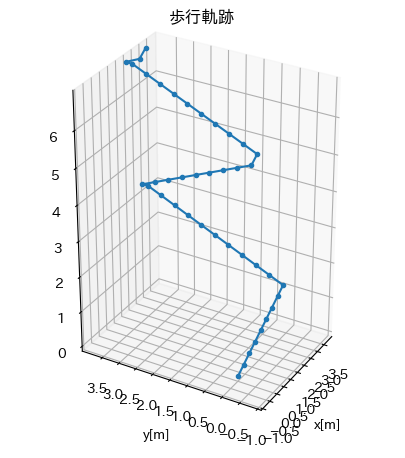

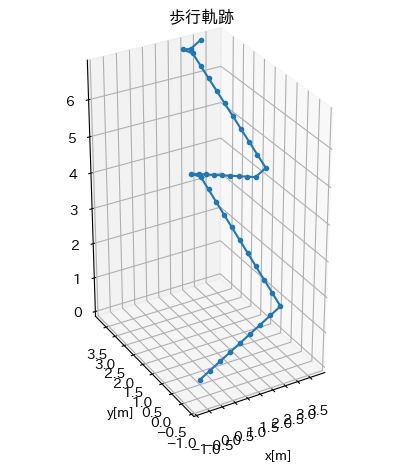

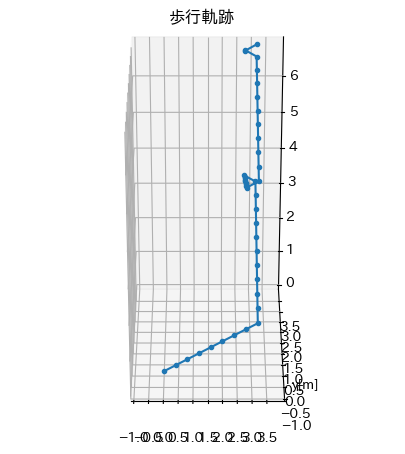

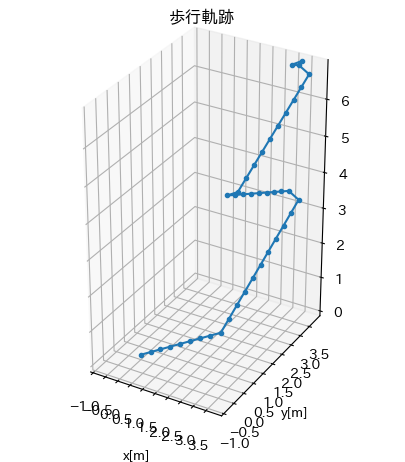

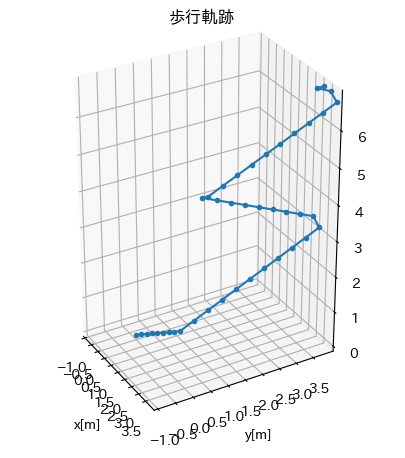

In [58]:
# 軌跡を描く
defalut_step = 0.4
step = 0.4
x,y,z = 0,0,0
point = [[0, 0,0]]
direction_status = 'default'
stairs = 9
stair = 0
for p in peek_stair:
    # p のときのpeek_df['position_pro_y'] == 1 かどうか判別
    if peek_df['status'][p] == 'stairs':
        # 1の時は1段上がっているので、z軸にstepを足す
        z += average_floor_step_high
        stair += 1
    else:
        z += 0
        step *= 4

    
    if direction_status == 'default':
        x += step
        y += 0
    elif direction_status == 'left1':
        x += 0
        y += step
    elif direction_status == 'left2':
        x -= step
        y += 0
    else:
        x += 0
        y -= step
    point.append([x, y,z])

    if p in peek_nears:
        if direction_status == 'default':
            direction_status = 'left1'
        elif direction_status == 'left1':
            direction_status = 'left2'
        elif direction_status == 'left2':
            direction_status = 'left3'
        else:
            direction_status = 'default'

    if step != defalut_step:
        step = defalut_step

# pointの[0,0]を削除する
point.pop(0)

point = pd.DataFrame(data=point, columns=['x', 'y','z'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]
point['z'] = point['z'] - point['z'][0]

size = ((-1,4),(-1,4))

# 視野の調整(30度ずつ)
for angle in range(0,360,30):

    # plot
    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(projection='3d')
    ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)

    # plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.title('歩行軌跡')
    plt.xlabel('x[m]')
    plt.ylabel('y[m]')

    plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
    plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
    plt.xlim(size[0][0], size[0][1])
    plt.ylim(size[1][0], size[1][1])


    ax.view_init(30, angle)

    plt.show()
